In [92]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc 
import imblearn

In [95]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 662864318186968359
xla_global_id: -1
]


# Problem Description

Cancer is a problem for all societies accross the globe and early detection increases survival rates. The goal of this model is to look at images of potentially cancerous cells and itentify them as having cancer or not. I have loaded all 6GB of cell images to train a convolutional nerual network on to classify each image as cancerous or not. 

This model will use keras and 2 convolutional layers to identify the cancer images. 

# Load Data

In [27]:
path = "cancer_images/" 
train_path = path + 'train/'
test_path = path + 'test/'

In [32]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 

df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0]) 
labels = pd.read_csv(r"cancer_images\train_labels.csv") 
df = df.merge(labels, on = "id") 

print(df)

                                                     path  \
0       cancer_images/train\00001b2b5609af42ab0ab276dd...   
1       cancer_images/train\000020de2aa6193f4c160e398a...   
2       cancer_images/train\00004aab08381d25d315384d64...   
3       cancer_images/train\0000d563d5cfafc4e68acb7c98...   
4       cancer_images/train\0000da768d06b879e5754c43e2...   
...                                                   ...   
220020  cancer_images/train\fffe6c73afcf5f5da5818fb70c...   
220021  cancer_images/train\fffeb3f5361ea57e728fb689e6...   
220022  cancer_images/train\fffeca85b16452a7709d163e05...   
220023  cancer_images/train\fffeeb1297fd4e26f247af648a...   
220024  cancer_images/train\ffffe55093358954f38bba4c35...   

                                              id  label  
0       00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1  
1       000020de2aa6193f4c160e398a8edea95b1da598      0  
2       00004aab08381d25d315384d646f5ce413ea24b1      0  
3       0000d563d5cfafc4e68acb7c982

# EDA

view random images
code referenced from: https://www.kaggle.com/code/conradkleykamp/histopathologic-cancer-detection-cnn-keras

In [ ]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df.to_numpy())[0:N]
    for i, row in tqdm.notebook.tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])     
    return X,y

In [76]:
N=10000
df_pos = df[df['label'] == 1].copy()
df_neg = df[df['label'] == 0].copy()

X, y = load_data(N=N,df=df)

# use this to balance dataset
#Xn,yn = load_data(N=N,df=df_neg)
#Xp,yp = load_data(N=N,df=df_pos) 

C:\Users\smark\AppData\Local\Temp\ipykernel_15292\4028851147.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/10000 [00:00<?, ?it/s]

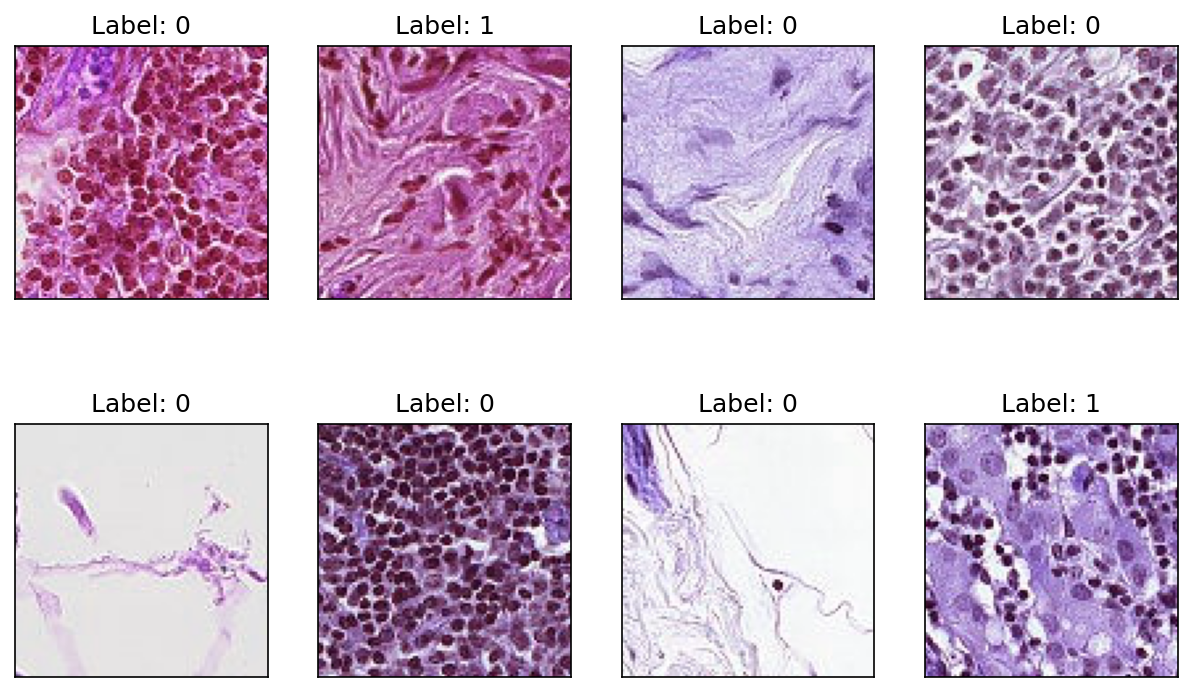

In [113]:

fig = plt.figure(figsize=(10, 6), dpi=150)
np.random.seed(42) 
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) 
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx][2])) 

Text(0, 0.5, 'Samples')

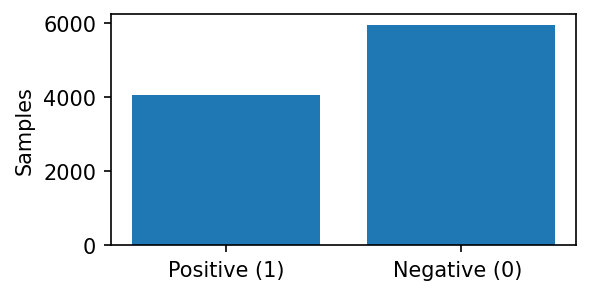

In [53]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); 
plt.xticks([1,0],["Negative (0) ","Positive (1)"]);
plt.ylabel("Samples")

# Build Model

In [86]:
#N = df["path"].size
N = 10000
X,y = load_data(N=N,df=df)

C:\Users\smark\AppData\Local\Temp\ipykernel_15292\4028851147.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [87]:
training_portion = 0.8 
split_idx = int(np.round(training_portion * y.shape[0])) 
np.random.seed(42) 

In [88]:
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [105]:
# Parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()

model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))


model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model.add(Dense(1, activation = "sigmoid"))

In [106]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

# Training

In [107]:
epochs = 3 
for epoch in range(epochs):
    iterations = np.floor(split_idx / batch_size).astype(int) 
    loss,acc = 0,0 
    with trange(iterations) as t: 
        for i in t:
            start_idx = i * batch_size 
            x_batch = X[start_idx:start_idx+batch_size] 
            y_batch = y[start_idx:start_idx+batch_size] 
            metrics = model.train_on_batch(x_batch.astype(float), y_batch[:,2].astype(float)) 
            loss = loss + metrics[0] 
            acc = acc + metrics[1] 
            t.set_description('Running training epoch ' + str(epoch)) 
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) 

Running training epoch 2: 100%|█████████████████████████████████| 160/160 [23:41<00:00,  8.88s/it, acc=0.84, loss=0.37]


# Validation

In [111]:
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) 
loss,acc = 0,0 
with trange(iterations) as t: 
    for i in t:
        start_idx = i * batch_size 
        x_batch = X[start_idx:start_idx+batch_size] 
        y_batch = y[start_idx:start_idx+batch_size] 
        metrics = model.test_on_batch(x_batch.astype(float), y_batch[:,2].astype(float)) 
        loss = loss + metrics[0] 
        acc = acc + metrics[1] 
        t.set_description('Running training') 
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

Running validation: 100%|█████████████████████████████████████████| 40/40 [00:11<00:00,  3.50it/s, acc=0.72, loss=0.54]

Validation loss: 0.538817373663187
Validation accuracy: 0.7200000032782554


In [ ]:
base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
file_batch = 5000 
max_idx = len(test_files) 
for idx in range(0, max_idx, file_batch): 
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) 
    test_df['id'] = test_df.path.map(lambda x: x.split('\\')[1].split(".")[0]) 
    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() 

Indexes: 0 - 5000
157/157 [==============================] - 56s 350ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 60s 381ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 61s 386ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 58s 373ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 58s 370ms/step
Indexes: 25000 - 30000
  6/157 [>.............................] - ETA: 43s